In [21]:
import numpy as np

import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics

import data_visualisation as dv
import data_augmentation as da

from sklearn.model_selection import KFold

# Load Data

In [18]:
thismodule = sys.modules[__name__]
NP_DATA = 'data/DAT_China.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(564, 1000, 12)
(564,)
(140, 1000, 12)
(140,)


In [27]:
# convert RBBB labels to Normal 
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

In [37]:
# distribution of classes
print(np.sum(Y_train) / len(Y_train))
print(np.sum(Y_test)/ len(Y_test))

0.25354609929078015
0.2357142857142857


# Visualise a sample of the data

(1000, 12)
0.0


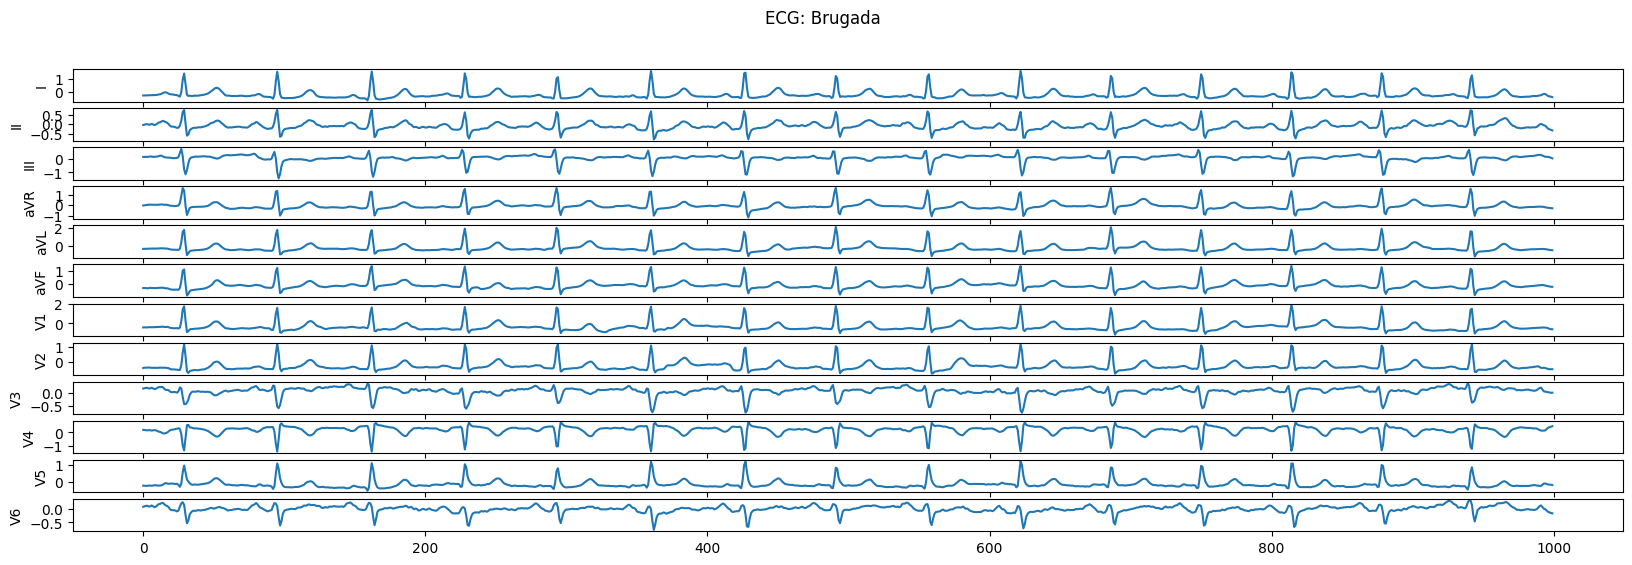

In [26]:
rand_index = np.random.randint(0, X_train.shape[0])
rand_sample = X_train[rand_index]
label = Y_train[rand_index]
label_text = Y_train_text[rand_index]
# rand_sample = Normal_data[0]
print(rand_sample.shape)
print(label)

dv.plot_12_lead_ecg(rand_sample, label_text)

# Create Model

In [20]:
import models.cnn as cnn

X_input = keras.Input(shape=X_train.shape[1:])
num_classes = 1
output, feature_extractor = cnn.model(X_input, num_classes=num_classes, filters=[32, 64, 128], kernels=[5,3,3], hidden_units=[128], dropout=[0.5])


# Pre-trained model

In [11]:
feature_extractor_model = keras.Model(inputs=X_input, outputs=feature_extractor)
feature_extractor_model.load_weights('models/cnn_model.keras', by_name=True)
# for layer in feature_extractor_model.layers:
#     layer.trainable = False
    
X = keras.layers.Dense(128, activation='relu')(feature_extractor)
X_out = keras.layers.Dense(num_classes, activation='sigmoid')(X)

new_model = keras.Model(inputs=X_input, outputs=X_out)
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [14]:
history = new_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.9819 - precision: 1.0000 - recall: 0.9516 - auc: 0.9998 - val_loss: 0.9626 - val_accuracy: 0.8298 - val_precision: 1.0000 - val_recall: 0.3846 - val_auc: 0.8462
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 0.9880 - precision: 1.0000 - recall: 0.9677 - auc: 0.9998 - val_loss: 0.3481 - val_accuracy: 0.9574 - val_precision: 1.0000 - val_recall: 0.8462 - val_auc: 0.9581
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.3177 - val_accuracy: 0.9574 - val_precision: 1.0000 - val_recall: 0.8462 - val_auc: 0.9548
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9970 - precision: 0.9920 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.3435 - val_accuracy: 0.9574 - val_precision: 1.0000 - val_recall: 0.846

In [22]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

# evaluate the model
y_pred = new_model.predict(X_test)
y_pred_binary = np.round(y_pred)
y_true = y_test

print(classification_report(y_true, y_pred_binary))

# AUC score
from sklearn.metrics import roc_auc_score

print("Accuracy score:", accuracy_score(y_true, y_pred_binary))
print("AUC score:", roc_auc_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred_binary))
print("Precision score:", precision_score(y_true, y_pred_binary))
print("Recall score:", recall_score(y_true, y_pred_binary))

3/3 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97        57
         1.0       0.97      0.92      0.95        39

    accuracy                           0.96        96
   macro avg       0.96      0.95      0.96        96
weighted avg       0.96      0.96      0.96        96

Accuracy score: 0.9583333333333334
AUC score: 0.9797570850202428
F1 score: 0.9473684210526315
Precision score: 0.972972972972973
Recall score: 0.9230769230769231


# Non Pretrained Model

In [16]:
model2, _ = cnn_model(X_input, num_classes=num_classes)

model2 = keras.Model(inputs=X_input, outputs=model2)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 27ms/step - loss: 0.6432 - accuracy: 0.6476 - precision_1: 0.5636 - recall_1: 0.2500 - auc_1: 0.6253 - val_loss: 0.6632 - val_accuracy: 0.7872 - val_precision_1: 0.6000 - val_recall_1: 0.6923 - val_auc_1: 0.7930
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5723 - accuracy: 0.6988 - precision_1: 0.7609 - recall_1: 0.2823 - auc_1: 0.7607 - val_loss: 0.7079 - val_accuracy: 0.4255 - val_precision_1: 0.3250 - val_recall_1: 1.0000 - val_auc_1: 0.7726
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5367 - accuracy: 0.7651 - precision_1: 0.7674 - recall_1: 0.5323 - auc_1: 0.8171 - val_loss: 0.6726 - val_accuracy: 0.7021 - val_precision_1: 0.4815 - val_recall_1: 1.0000 - val_auc_1: 0.8122
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4427 - accuracy: 0.8343 - precision_1: 0.8791 - recall_1: 0.6452 - auc_1: 0.8888 - val_loss: 0.6187 - val_accuracy: 0.7872 

In [64]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

output, feature_extractor = cnn.model(X_input, num_classes=num_classes, filters=[32, 64, 128], kernels=[5,3,3], hidden_units=[128], dropout=[0.5])

model2 = keras.Model(inputs=X_input, outputs=output)

k = 8
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Training on fold {i+1}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    # reset the weights of the model 
    model = keras.Model(inputs=X_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
    
    model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=50, batch_size=32, verbose=0)
    
    print(f"Evaluating the model for fold {i+1}")
    Y_pred_fold = model.predict(X_test, verbose=0)
    Y_pred_binary_fold = np.round(Y_pred_fold)
    Y_true_fold = Y_test
    
    #F1 score
    print(f"F1 score for fold {i+1}", f1_score(Y_true_fold, Y_pred_binary_fold))
    print(f"Accuracy score for fold {i+1}", accuracy_score(Y_true_fold, Y_pred_binary_fold))

Training on fold 1
Evaluating the model for fold 1
5/5 [==============================] - 0s 1ms/step
F1 score for fold 1 0.9117647058823529
Accuracy score for fold 1 0.9571428571428572
Training on fold 2
Evaluating the model for fold 2
5/5 [==============================] - 0s 2ms/step
F1 score for fold 2 0.9253731343283583
Accuracy score for fold 2 0.9642857142857143
Training on fold 3
Evaluating the model for fold 3
5/5 [==============================] - 0s 2ms/step
F1 score for fold 3 0.8985507246376813
Accuracy score for fold 3 0.95
Training on fold 4
Evaluating the model for fold 4
5/5 [==============================] - 0s 1ms/step
F1 score for fold 4 0.8823529411764706
Accuracy score for fold 4 0.9428571428571428
Training on fold 5
Evaluating the model for fold 5
5/5 [==============================] - 0s 1ms/step
F1 score for fold 5 0.8732394366197183
Accuracy score for fold 5 0.9357142857142857
Training on fold 6
Evaluating the model for fold 6
5/5 [============================

In [62]:
print(np.sum(Y_train) / len(Y_train))
print(np.sum(Y_test)/ len(Y_test))

print(Y_test)

0.25354609929078015
0.2357142857142857
[False False  True False False False False  True False False False False
 False False False  True False False False False False  True False False
  True False False False False False False False False  True False False
 False False False  True  True False False  True False False False  True
 False  True False False False False False False False False False  True
  True False False False False False False  True  True False  True False
  True False False False False False  True False False False  True False
 False False False False False False False False False False False False
 False False False  True  True False False False  True False False False
 False  True False False False  True False False False  True False False
  True  True False  True  True False  True  True False  True False  True
 False False False False False False False False]


5/5 [==============================] - 0s 680us/step
              precision    recall  f1-score   support

       False       0.74      0.51      0.61       107
        True       0.21      0.42      0.28        33

    accuracy                           0.49       140
   macro avg       0.48      0.47      0.45       140
weighted avg       0.62      0.49      0.53       140

Accuracy score: 0.4928571428571429


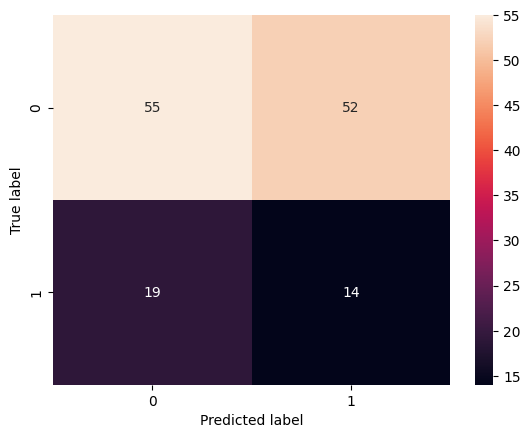

In [63]:
# model with random prediction
def random_prediction_model(X):
    random_out = keras.layers.Lambda(lambda x: tf.random.uniform([tf.shape(x)[0], 1], minval=0, maxval=1))(X)
    model = keras.Model(inputs=X, outputs=random_out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
    return model

model_rand = random_prediction_model(X_input)

#evaluate the model
Y_pred_rand = model_rand.predict(X_test)
Y_pred_binary_rand = np.round(Y_pred_rand)
Y_true_rand = Y_test

print(classification_report(Y_true_rand, Y_pred_binary_rand))
print("Accuracy score:", accuracy_score(Y_true_rand, Y_pred_binary_rand))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_true_rand, Y_pred_binary_rand)
sns.heatmap(cm, annot=True, fmt='d')
# label the acis
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()





In [21]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# evaluate the model
y_pred = model2.predict(X_test)
y_pred_binary = np.round(y_pred)
y_true = y_test

print(classification_report(y_true, y_pred_binary))



print("Accuracy score:", accuracy_score(y_true, y_pred_binary))
print("AUC score:", roc_auc_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred_binary))
print("Precision score:", precision_score(y_true, y_pred_binary))
print("Recall score:", recall_score(y_true, y_pred_binary))

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96        57
         1.0       0.97      0.90      0.93        39

    accuracy                           0.95        96
   macro avg       0.95      0.94      0.95        96
weighted avg       0.95      0.95      0.95        96

Accuracy score: 0.9479166666666666
AUC score: 0.9914529914529915
F1 score: 0.9333333333333333
Precision score: 0.9722222222222222
Recall score: 0.8974358974358975
